In [1]:
import cv2
import dlib
import time
import sys
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import math

# url = "https://www.youtube.com/watch?v=SIZNf_Ydplg"
epsilon = sys.float_info.epsilon

In [15]:
def get_face_size(face_landmarks):
    face_width = (face_landmarks.part(16).x - face_landmarks.part(0).x)
    face_height = (face_landmarks.part(8).y - face_landmarks.part(27).y)
    return face_width, face_height

# def get_face_pitch(face_landmarks):
#     upper_nose_length = np.linalg.norm(np.array([face_landmarks.part(33).x, face_landmarks.part(33).y]) - np.array([face_landmarks.part(62).x, face_landmarks.part(62).y]))
#     lower_nose_length = np.linalg.norm(np.array([face_landmarks.part(8).x, face_landmarks.part(8).y]) - np.array([face_landmarks.part(62).x, face_landmarks.part(62).y]))
#     angle = np.arccos((upper_nose_length-lower_nose_length)/(upper_nose_length+lower_nose_length+epsilon))
#     return math.degrees(angle)
     
def get_face_roll(face_landmarks):
    # check what is the tilt of the face. tilt is the angle between the line joining the eyes and the horizontal line
    x_eye_left = (face_landmarks.part(37).x + face_landmarks.part(38).x+face_landmarks.part(40).x+face_landmarks.part(41).x)/4
    y_eye_left = (face_landmarks.part(37).y + face_landmarks.part(38).y+face_landmarks.part(40).y+face_landmarks.part(41).y)/4
    x_eye_right = (face_landmarks.part(43).x + face_landmarks.part(44).x+face_landmarks.part(46).x+face_landmarks.part(47).x)/4
    y_eye_right = (face_landmarks.part(43).y + face_landmarks.part(44).y+face_landmarks.part(46).y+face_landmarks.part(47).y)/4
    angle = np.arctan((y_eye_right - y_eye_left)/(x_eye_right - x_eye_left))
    return math.degrees(angle)

def get_face_yaw(face_landmarks):
    # length of temple line is the distance between the points 1 and 36 (left) and 15 and 45 (right)
    left_temple = np.linalg.norm(np.array([face_landmarks.part(0).x, face_landmarks.part(0).y]) - np.array([face_landmarks.part(16).x, face_landmarks.part(16).y]))
    right_temple = np.linalg.norm(np.array([face_landmarks.part(15).x, face_landmarks.part(15).y]) - np.array([face_landmarks.part(45).x, face_landmarks.part(45).y]))
    return math.degrees((left_temple - right_temple)/(left_temple + right_temple)) -30
    

def add_data(frame2, face_landmarks_np, scale_factor):
    for n in range(0, 68):
                _, indices = kdtree.query(face_landmarks_np[n], k+1)
                for neighbor_index in indices[1:]:
                    neighbor = face_landmarks_np[neighbor_index]
                    distance = np.linalg.norm(face_landmarks_np[n] - neighbor)
                    if distance < face_width/5:
                        cv2.line(frame2, (face_landmarks_np[n][0]*scale_factor, face_landmarks_np[n][1]*scale_factor), (neighbor[0]*scale_factor, neighbor[1]*scale_factor), (0, 200, 0), 1)
                        pass
                x = face_landmarks.part(n).x*scale_factor
                y = face_landmarks.part(n).y*scale_factor
                cv2.circle(frame2, (x, y), 1, (0, 0, 255), 1)
                # cv2.putText(frame2, str(n), (x, y), cv2.FONT_HERSHEY_SIMPLEX, .3, (0, 255, 0), 1)

    return frame2

In [3]:
def filter_glasses(frame2, face_landmarks, scale_factor):
    x_eye_left = int(scale_factor*(face_landmarks.part(27).x + face_landmarks.part(28).x)/2)
    y_eye_left = int(scale_factor*(face_landmarks.part(27).y + face_landmarks.part(28).y)/2)
    # x_eye_right = int(scale_factor*(face_landmarks.part(43).x + face_landmarks.part(44).x+face_landmarks.part(46).x+face_landmarks.part(47).x)/4)
    # y_eye_right = int(scale_factor*(face_landmarks.part(43).y + face_landmarks.part(44).y+face_landmarks.part(46).y+face_landmarks.part(47).y)/4)
    return filter_generic(frame2, face_landmarks, "glasses222.png", x_eye_left, y_eye_left)


def filter_mustache(frame2, face_landmarks, scale_factor):
    x_mustache = int(scale_factor*(face_landmarks.part(50).x + face_landmarks.part(52).x)/2)
    y_mustache = int(scale_factor*(face_landmarks.part(51).y + face_landmarks.part(33).y)/2)
    return filter_generic(frame2, face_landmarks, "mustache2.png", x_mustache, y_mustache)

photo = {}


def filter_generic(frame2, face_landmarks, file_name, x, y):
    face_width, _ = get_face_size(face_landmarks)
    roll = get_face_roll(face_landmarks)
    yaw = get_face_yaw(face_landmarks)
    if file_name in photo:
        filter = photo[file_name]
    else :
        filter = cv2.imread(file_name, -1)
        photo[file_name] = filter
    filter_width = int(filter.shape[1]*face_width/100)
    filter_height = int(filter.shape[0]*face_width/100)
    filter = cv2.resize(filter, (filter_width, filter_height))
    padding = int(np.ceil(np.sqrt(2) * max(filter_width, filter_height) / 2 - max(filter_width, filter_height) / 2))
    filter = cv2.copyMakeBorder(filter, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
    x_filter = x - int(filter.shape[1]/2)
    y_filter = y - int(filter.shape[0]/2)
    center = (filter.shape[1] // 2, filter.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, -roll, 1.0)
    filter = cv2.warpAffine(filter, rotation_matrix, (filter.shape[1], filter.shape[0]))

    # desired_width = filter_width/2
    # desired_height = filter_height/2
    # target_points = np.array([[0, 0], [desired_width, 0], [0, desired_height], [desired_width, desired_height]], dtype=np.float32)

    # # Compute the perspective transformation matrix
    # perspective_matrix = cv2.getPerspectiveTransform(np.array([[0, 0], [filter_width, 0], [0, filter_height], [filter_width, filter_height]], dtype=np.float32), target_points)

    # # Apply the perspective transformation to the rotated image
    # filter = cv2.warpPerspective(filter, perspective_matrix, (desired_width, desired_height))



    y1, y2 = y_filter, y_filter + filter.shape[0]
    x1, x2 = x_filter, x_filter + filter.shape[1]
    alpha_s = filter[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s
    for c in range(0, 3):
        frame2[y1:y2, x1:x2, c] = (alpha_s * filter[:, :, c] + alpha_l * frame2[y1:y2, x1:x2, c])
    return frame2



In [16]:
first_time = time.time()
print("started at = ", time.strftime("%H:%M:%S", time.localtime()))


cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# cap = cv2.VideoCapture("own.mp4")
temp_time = time.time()
print("time to start camera = ", temp_time - first_time)


scale_factor = 2
# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# print("width = ", width, "height = ", height, "scale_factor = ", scale_factor)
width = 1280
height = 720
print("width = ", width, "height = ", height, "scale_factor = ", scale_factor)
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, int(width/scale_factor))
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, int(height/scale_factor))
print("time to set camera = ", time.time() - temp_time)
temp_time = time.time()

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("updated width = ", width, "height = ", height)


hog_face_detector = dlib.get_frontal_face_detector()
dlib_facelandmark = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
print("time to load dlib = ", time.time() - temp_time)
temp_time = time.time()

i = 0
curr_i = 0
start_time = time.time()
last_time = time.time()
loop_time = time.time()

vis = True

cum_read_frame_time = 0
cum_detect_face_time = 0
cum_feature_time = 0
cum_draw_time = 0


while True:
    # print("\nframe number ", i)
    i = i+1
    curr_i = curr_i+1
    cur_time = time.time()

    _, frame = cap.read()
    if frame is None:
        break
    frame2 = frame.copy()

    frame = cv2.resize(frame, (int(width/scale_factor), int(height/scale_factor)))
    # print("time to read frame = ", time.time() - temp_time)
    cum_read_frame_time += time.time() - temp_time
    temp_time = time.time()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = hog_face_detector(gray)
    # print("time to detect faces = ", time.time() - temp_time)
    cum_detect_face_time += time.time() - temp_time
    temp_time = time.time()
    for face in faces:
        rectangle_np = np.array([face.left()*scale_factor, face.top()*scale_factor, face.right()*scale_factor, face.bottom()*scale_factor])
        face_width = (face.right() - face.left())*scale_factor
        face_height = (face.bottom() - face.top())*scale_factor
        cv2.rectangle(frame2, (face.left()*scale_factor, face.top()*scale_factor),(face.right()*scale_factor, face.bottom()*scale_factor), (255, 0, 0), 2)
        
        face_landmarks = dlib_facelandmark(gray, face)
        # print("time to get features = ", time.time() - temp_time)
        cum_feature_time += time.time() - temp_time
        temp_time = time.time()
        face_landmarks_np = np.array([[p.x, p.y] for p in face_landmarks.parts()])
        kdtree = cKDTree(face_landmarks_np)
        k = 4

        if vis:
            frame2 = add_data(frame2, face_landmarks_np, scale_factor)
            pass
        frame2 = filter_glasses(frame2, face_landmarks,scale_factor)
        # frame2 = filter_mustache(frame2, face_landmarks, scale_factor)
        frame2 = filter_mustache(frame2, face_landmarks, scale_factor)
        # put text on the frame of the face orientation

    # print("time to draw landmarks = ", time.time() - temp_time)
    cum_draw_time += time.time() - temp_time
    temp_time = time.time()
    # print("overall time = ", time.time() - first_time)

    if curr_i % 50 == 0:
        curr_i = 0
        last_time = time.time()
    fps = curr_i/(cur_time - last_time+epsilon)
    cv2.putText(frame2, "fps: " + str(fps), (10, 90),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 255), 1)
    cv2.putText(frame2, "Time: " + str(cur_time - start_time),(10, 60), cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 255), 1)
    cv2.putText(frame2, "Frame: " + str(i), (10, 30),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 255), 1)
    cv2.putText(frame2, str(width) + "x"+str(height), (10, 120),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 255), 1)
    cv2.putText(frame2, "face roll: " + str(round(get_face_roll(face_landmarks),2)), (10, 150),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 255), 1)
    cv2.putText(frame2, "face yaw: " + str(round(get_face_yaw(face_landmarks),2)), (10, 180),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 255), 1)
    # cv2.putText(frame2, "face pitch: " + str(round(get_face_pitch(face_landmarks),2)), (10, 210),cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 255, 255), 1)
    # cv2.imshow("Face Landmarks", frame)
    cv2.imshow("Face full size", frame2)

    key = cv2.waitKey(1)
    if key == 27:
        break

print("\n\ntime precentages: ")
print("read frames = ", round(100*cum_read_frame_time/(time.time() - loop_time +epsilon), 2), "%")
print("detect faces = ", round(100*cum_detect_face_time/(time.time() - loop_time+epsilon), 2), "%")
print("feature from face = ", round(100*cum_feature_time/(time.time() - loop_time+epsilon), 2), "%")
print("draw annotations = ", round(100*cum_draw_time/(time.time() - loop_time+epsilon), 2), "%")
print("total time = ", round(time.time() - loop_time, 2), "sec")
print("overall fps = ", round(i/(cur_time - start_time+epsilon), 2), "fps")
cap.release()
cv2.destroyAllWindows()

started at =  15:29:45
time to start camera =  0.5959787368774414
width =  1280 height =  720 scale_factor =  2
time to set camera =  0.0010859966278076172
updated width =  640 height =  480
time to load dlib =  2.808743953704834


time precentages: 
read frames =  76.8 %
detect faces =  14.65 %
feature from face =  1.98 %
draw annotations =  6.52 %
total time =  5.93 sec
overall fps =  7.94 fps


<class '_dlib_pybind11.points'>
(68, 2)


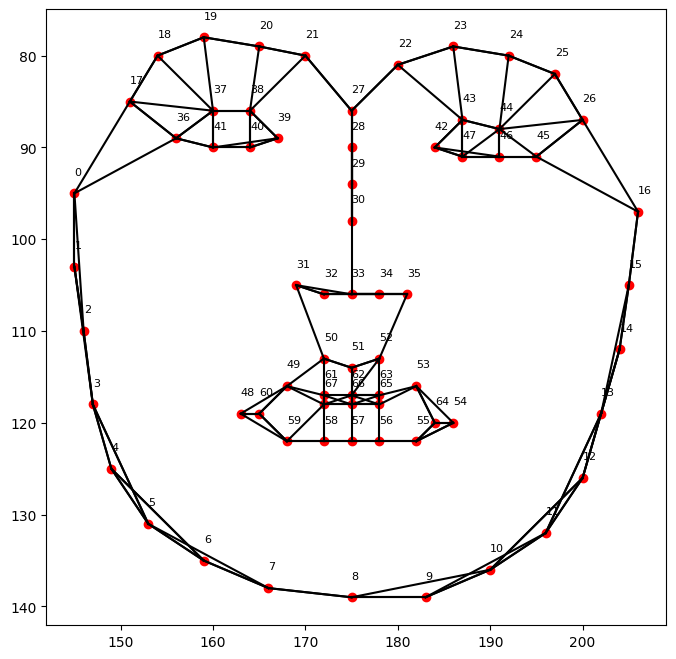

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def connect_closest_points(ax, points, k=5):
    # Build KD-tree for efficient nearest neighbor search
    kdtree = cKDTree(points)

    # Iterate through each point
    for i, point in enumerate(points):
        # Query k+1 neighbors (including the point itself)
        _, indices = kdtree.query(point, k+1)

        # Connect the point with its k closest neighbors
        for neighbor_index in indices[1:]:  # Skip the point itself
            neighbor = points[neighbor_index]
            # calc distance between point and neighbor
            distance = np.linalg.norm(point - neighbor)
            if distance < 3000:
                ax.plot([point[0], neighbor[0]], [point[1], neighbor[1]], color='black')


print(type(face_landmarks.parts()))
face_landmarks_np = np.array([[point.x, point.y] for point in face_landmarks.parts()])
print(face_landmarks_np.shape)

fig, ax = plt.subplots()
# invert y axis
ax.invert_yaxis()
ax.scatter(face_landmarks_np[:, 0], face_landmarks_np[:, 1], color='red')  # Scatter plot of points
# add numbers to points
for i, txt in enumerate(face_landmarks_np):
    ax.annotate(i, (face_landmarks_np[i, 0], face_landmarks_np[i, 1]-2), fontsize=8, color='black')

connect_closest_points(ax, face_landmarks_np, k=3)  # Connect each point with its 5 closest neighbors
# set the size of the plot to twice 
fig.set_size_inches(8, 8)


plt.show()


<class '_dlib_pybind11.points'>
(68, 2)
pitch =  26.991466561591622 yaw =  -63.008533438408385 roll =  -157.43073691321555


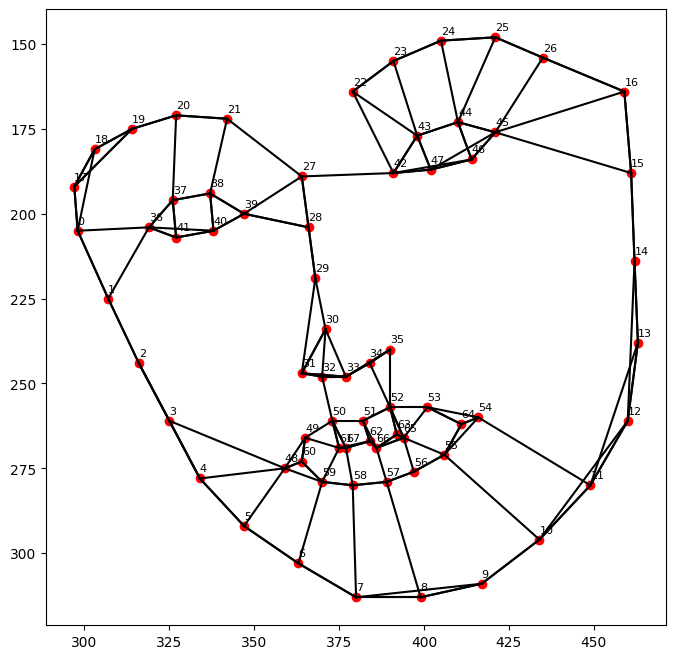

In [19]:
def calculate_pitch_yaw_roll(face_landmarks):
    # Extract relevant landmarks for orientation estimation
    left_eye_center = np.array([face_landmarks.part(45).x + face_landmarks.part(42).x, face_landmarks.part(45).y + face_landmarks.part(42).y])
    right_eye_center = np.array([face_landmarks.part(36).x + face_landmarks.part(39).y, face_landmarks.part(36).y + face_landmarks.part(39).y])
    nose_tip = np.array([face_landmarks.part(30).x, face_landmarks.part(30).y])
    mouth_center = np.array([face_landmarks.part(62).x, face_landmarks.part(62).y])

    # Compute direction vectors for specific facial features
    eye_direction = np.array([right_eye_center[0] - left_eye_center[0], right_eye_center[1] - left_eye_center[1]])
    nose_direction = np.array([nose_tip[0] - (left_eye_center[0] + right_eye_center[0]) / 2,
                               nose_tip[1] - (left_eye_center[1] + right_eye_center[1]) / 2])
    mouth_direction = np.array([mouth_center[0] - (left_eye_center[0] + right_eye_center[0]) / 2,
                                mouth_center[1] - (left_eye_center[1] + right_eye_center[1]) / 2])

    # Calculate pitch angle (rotation around x-axis)
    pitch = -np.arcsin(nose_direction[1] / np.linalg.norm(nose_direction))

    # Calculate yaw angle (rotation around y-axis)
    yaw = np.arctan2(nose_direction[0], -nose_direction[1])

    # Calculate roll angle (rotation around z-axis)
    roll = np.arctan2(mouth_direction[1], mouth_direction[0])

    # return -90 - math.degrees(pitch), -180 - math.degrees(yaw), math.degrees(roll)
    return math.degrees(pitch), math.degrees(yaw), math.degrees(roll)


image = cv2.imread("face1.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = hog_face_detector(gray)
face_landmarks = dlib_facelandmark(gray, faces[0])

print(type(face_landmarks.parts()))
face_landmarks_np = np.array([[point.x, point.y] for point in face_landmarks.parts()])
print(face_landmarks_np.shape)

fig, ax = plt.subplots()
# invert y axis
ax.invert_yaxis()
ax.scatter(face_landmarks_np[:, 0], face_landmarks_np[:, 1], color='red')  # Scatter plot of points
# add numbers to points
for i, txt in enumerate(face_landmarks_np):
    ax.annotate(i, (face_landmarks_np[i, 0], face_landmarks_np[i, 1]-2), fontsize=8, color='black')

connect_closest_points(ax, face_landmarks_np, k=3)  # Connect each point with its 5 closest neighbors
# set the size of the plot to twice 
fig.set_size_inches(8, 8)
pitch, yaw, roll = calculate_pitch_yaw_roll(face_landmarks)
print("pitch = ", pitch, "yaw = ", yaw, "roll = ", roll)


plt.show()


In [20]:
def filter_mustache_old(frame2, face_landmarks, scale_factor):
    face_width, face_height = get_face_size(face_landmarks)
    orientation = get_face_orientation(face_landmarks)

    mustache = cv2.imread("mustache2.png", -1)
    mustache_width = int(mustache.shape[1]*face_width/100)
    mustache_height = int(mustache.shape[0]*face_width/100)
    mustache = cv2.resize(mustache, (mustache_width, mustache_height))
    # cv2.circle(frame2, (x_mustache, y_mustache), 1, (0, 0, 255), 4)

    # rot_mat = cv2.getRotationMatrix2D((x_mustache,y_mustache), orientation, 1.0)
    # mustache = cv2.warpAffine(mustache, rot_mat, mustache.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    
    padding = int(np.ceil(np.sqrt(2) * max(mustache_width, mustache_height) / 2 - max(mustache_width, mustache_height) / 2))
    mustache = cv2.copyMakeBorder(mustache, padding, padding, padding, padding, cv2.BORDER_CONSTANT)

    x_mustache = int(scale_factor*(face_landmarks.part(50).x + face_landmarks.part(52).x)/2) - int(mustache.shape[1]/2)
    y_mustache = int(scale_factor*(face_landmarks.part(51).y + face_landmarks.part(33).y)/2) - int(mustache.shape[0]/2)


    center = (mustache.shape[1] // 2, mustache.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, -orientation, 1.0)
    mustache = cv2.warpAffine(mustache, rotation_matrix, (mustache.shape[1], mustache.shape[0]))
  
    # padX = [int(mustache.shape[1] - mustache_width/2), int(mustache_width/2)]
    # padY = [int(mustache.shape[0] - mustache_height/2), int(mustache_height/2)]
    # mustache = np.pad(mustache, [padY, padX], 'constant')
    # mustache = ndimage.rotate(mustache, -orientation)
    # mustache = mustache[padY[0] : -padY[1], padX[0] : -padX[1]]

    
    y1, y2 = y_mustache, y_mustache + mustache.shape[0]
    x1, x2 = x_mustache, x_mustache + mustache.shape[1]
    alpha_s = mustache[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s

    for c in range(0, 3):
        frame2[y1:y2, x1:x2, c] = (alpha_s * mustache[:, :, c] + alpha_l * frame2[y1:y2, x1:x2, c])

    return frame2


def filter_eyes_old(frame2, face_landmarks, scale_factor):
    x_eye_left = int(scale_factor*(face_landmarks.part(37).x + face_landmarks.part(38).x+face_landmarks.part(40).x+face_landmarks.part(41).x)/4)
    y_eye_left = int(scale_factor*(face_landmarks.part(37).y + face_landmarks.part(38).y+face_landmarks.part(40).y+face_landmarks.part(41).y)/4)
    x_eye_right = int(scale_factor*(face_landmarks.part(43).x + face_landmarks.part(44).x+face_landmarks.part(46).x+face_landmarks.part(47).x)/4)
    y_eye_right = int(scale_factor*(face_landmarks.part(43).y + face_landmarks.part(44).y+face_landmarks.part(46).y+face_landmarks.part(47).y)/4)
    cv2.circle(frame2, (x_eye_left, y_eye_left), 1, (255, 255, 255), 3)
    cv2.circle(frame2, (x_eye_right, y_eye_right), 1, (255, 255, 255), 3)
    return frame2

In [21]:
def face_orientation(frame, landmarks):
    size = frame.shape #(height, width, color_channel)
    image_points = np.array([
                            (landmarks[4], landmarks[5]),     # Nose tip
                            (landmarks[10], landmarks[11]),   # Chin
                            (landmarks[0], landmarks[1]),     # Left eye left corner
                            (landmarks[2], landmarks[3]),     # Right eye right corne
                            (landmarks[6], landmarks[7]),     # Left Mouth corner
                            (landmarks[8], landmarks[9])      # Right mouth corner
                        ], dtype="double")

                           
    model_points = np.array([
                            (0.0, 0.0, 0.0),             # Nose tip
                            (0.0, -330.0, -65.0),        # Chin
                            (-165.0, 170.0, -135.0),     # Left eye left corner
                            (165.0, 170.0, -135.0),      # Right eye right corne
                            (-150.0, -150.0, -125.0),    # Left Mouth corner
                            (150.0, -150.0, -125.0)      # Right mouth corner                         
                        ])
    # Camera internals
 
    center = (size[1]/2, size[0]/2)
    focal_length = center[0] / np.tan(60/2 * np.pi / 180)
    camera_matrix = np.array(
                         [[focal_length, 0, center[0]],
                         [0, focal_length, center[1]],
                         [0, 0, 1]], dtype = "double"
                         )

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.CV_ITERATIVE)
    
    axis = np.float32([[500,0,0], 
                          [0,500,0], 
                          [0,0,500]])
                          
    imgpts, jac = cv2.projectPoints(axis, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    modelpts, jac2 = cv2.projectPoints(model_points, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]

    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6] 

    
    pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]


    pitch = math.degrees(math.asin(math.sin(pitch)))
    roll = -math.degrees(math.asin(math.sin(roll)))
    yaw = math.degrees(math.asin(math.sin(yaw)))

    return imgpts, modelpts, (str(int(roll)), str(int(pitch)), str(int(yaw))), (landmarks[4], landmarks[5])

frame = cv2.imread("face1.jpg")
imgpts, modelpts, rotate_degree, nose = face_orientation(frame, landmarks)

cv2.line(frame, nose, tuple(imgpts[1].ravel()), (0,255,0), 3) #GREEN
cv2.line(frame, nose, tuple(imgpts[0].ravel()), (255,0,), 3) #BLUE
cv2.line(frame, nose, tuple(imgpts[2].ravel()), (0,0,255), 3) #RED

remapping = [2,3,0,4,5,1]
for index in range(len(landmarks)/2):
    random_color = tuple(np.random.random_integers(0,255,size=3))

    cv2.circle(frame, (landmarks[index*2], landmarks[index*2+1]), 5, random_color, -1)  
    cv2.circle(frame,  tuple(modelpts[remapping[index]].ravel().astype(int)), 2, random_color, -1)  
    
        
#    cv2.putText(frame, rotate_degree[0]+' '+rotate_degree[1]+' '+rotate_degree[2], (10, 30),
#                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0),
#                thickness=2, lineType=2)
            
for j in xrange(len(rotate_degree)):
            cv2.putText(frame, ('{:05.2f}').format(float(rotate_degree[j])), (10, 30 + (50 * j)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), thickness=2, lineType=2)


NameError: name 'landmarks' is not defined